In [1]:
import torch
import numpy as np
import gym
import torch.nn as nn
import time
import random
import torch.optim as optim
import math


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
# Network architecture for DQN
class q_network(nn.Module):
    def __init__(self, observations, actions):
        super(q_network, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(observations, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, actions),
        )
    def forward(self, x):
        return self.network(x)

In [3]:
done = False
learning_rate = 0.0001
discount= 0.99
epsilon = 0.95
epsilon_decay = 0.9999
min_epsilon = 0.1
n_episodes = 1000
batch_size = 128
Reward_Path = 'rewards.npy'
env_name = 'CartPole-v0'
model_path = './models/' + env_name + '.pth'

print(epsilon)

0.95


In [4]:
# creating a cartpole environment
env = gym.make(env_name)
env.reset()

array([-0.00270691, -0.01540017,  0.0037088 ,  0.01664034])

In [5]:
'''
# Testing the environment with random actions
for _ in range(1000):
    env.render(100)
    time.sleep(0.05)
    env.step(env.action_space.sample())
env.close()
'''

'\n# Testing the environment with random actions\nfor _ in range(1000):\n    env.render(100)\n    time.sleep(0.05)\n    env.step(env.action_space.sample())\nenv.close()\n'

In [6]:
# for experience replay
from collections import deque

class Exp_Replay:
    def __init__(self, limit):
        self.memory = deque(maxlen=limit)     
        
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state,0)
        next_state = np.expand_dims(next_state,0)

        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.memory)

In [7]:
# creating object for network
q_hat = q_network(env.observation_space.shape[0], env.action_space.n).to(device)
q_hat_target = q_network(env.observation_space.shape[0], env.action_space.n).to(device)

q_hat_target.load_state_dict(q_hat.state_dict())

<All keys matched successfully>

In [8]:
criterion = nn.MSELoss().to(device)
optimizer = optim.RMSprop(q_hat.parameters(), lr = learning_rate)

memory = Exp_Replay(10000)

In [9]:
def plot(episode, avg_loss, eps, eps_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode: %5d | Epsilon: %4.2f | Avg. Reward: %5.2f'%(episode, eps, np.mean(ep_rewards[-50:])))
    plt.plot(eps_rewards)
    plt.subplot(132)
    plt.title('loss | Average Loss: %5.2f'%np.mean(ep_loss[-50:]))
    plt.plot(ep_loss)
    plt.show()

In [10]:
def action_select(state, epsilon):
    
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        state   = torch.FloatTensor(state).unsqueeze(0).to(device) 
        action = torch.argmax(q_hat(state)).item()
    
    return action

In [11]:
def compute_td_loss(batch_size,criterion, optimizer, target_net, loss, limit):
    if limit< batch_size:
        return 0
    
    state, action, reward, next_state, done = memory.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state)).to(device)
    next_state = torch.FloatTensor(np.float32(next_state)).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)
    
    current_q = q_hat(state).gather(1, action.unsqueeze(1)).squeeze(1)
    
        
    next_q    = target_net(next_state).max(dim=1)[0]
    q_target     = reward + discount*next_q*(1 - done)
    
    tdloss = criterion(current_q, q_target.detach())
    loss += tdloss.item()
    
    optimizer.zero_grad()
    tdloss.backward()
    optimizer.step()
    
    return loss

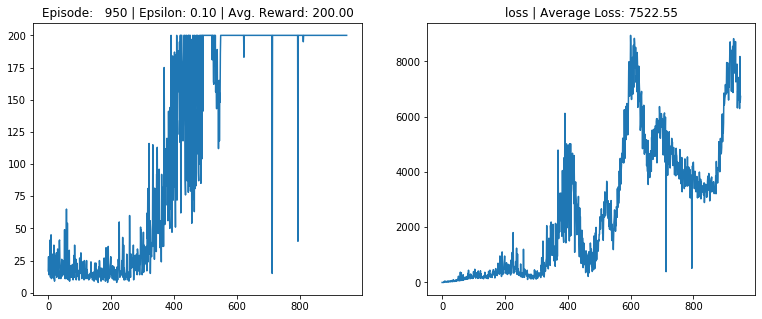

In [12]:
avg_loss = 0
steps = 200
ep_rewards = np.array([])
ep_loss = np.array([])

# Training the agent
for episode in range(n_episodes):
    state = env.reset()
    ep_reward = 0
    running_loss = 0
    done = False
    
    while not done:
        
        action = action_select(state, epsilon)
        epsilon = max(epsilon*epsilon_decay, min_epsilon)
        
        
        next_state, reward, done, _ = env.step(action)
        
        ep_reward += reward
        memory.push(state, action, reward, next_state, done)
        
        state = next_state
        
        running_loss = compute_td_loss(batch_size,criterion, optimizer, q_hat_target, running_loss, len(memory))
        
    ep_rewards = np.append(ep_rewards, ep_reward)
    ep_loss = np.append(ep_loss, running_loss)
    q_hat_target.load_state_dict(q_hat.state_dict())
            
    if episode%50==0:
        plot(episode, ep_loss, epsilon, ep_rewards)
        avg_loss = 0
        ep_reward =0
        np.save(Reward_Path, ep_rewards)
    
env.close()

In [14]:
# Save model
torch.save(q_hat_target.state_dict(),model_path)

q_hat_target = q_network(env.observation_space.shape[0], env.action_space.n).to(device)
q_hat_target.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
import gym
import time

env = gym.make(env_name)
# env.reset()
state = env.reset()
done = False
testing_epsilon = 0.05
tot_reward = 0

for step in range(2000):
    state = torch.from_numpy(state).float().to(device)
    env.render()
    action = torch.argmax(q_hat_target(state)).item()
    state, reward, done, _ = env.step(action)
    tot_reward += reward
    if done:
#         print('DONE')
        break
    time.sleep(.05)
    
print('Total Reward:', tot_reward)
    
env.close()

Total Reward: 200.0
